#  Assignment 1 - Language model foundations 💬

Welcome to the **1st assignment** for the **CS-552: Modern NLP course**!

> - 😀 Name: **Amey Kulkarni**
> - ✉️ Email: **amey.kulkarni@epfl.ch**
> - 🪪 SCIPER: **353055**

<div style="padding:15px 20px 20px 20px;border-left:3px solid orange;background-color:#fff5d6;border-radius: 20px;">

## How to implement this assignment

Please read carefully the following points. All the information on how to read, implement and submit your assignment is explained in detail below.

1. For this assignment, you will need to implement and fill in the missing code snippets for both the **Jupyter Notebook** `assignment1.ipynb` and the **`utils.py`** python file. In the `utils.py` file, you will add all the Dataset and Model classes you will implement according to the skeleton present in the file. In the notebook, you will add the data preprocessing pipeline for all the datasets, the training and testing pipelines of all implemented models and the report (See diagram below). 
    
![assignment_1_arch.png](https://github.com/CS-552/a1-amey-kulkarni27/blob/main/docs/assignment_1_arch.png?raw=1)

2. To implement your coding part, you can import the external libraries we provide in the `requirements.txt` file, however, you should not use any other package non included in these requirements. 

3. At the end of the notebook, you will need to fill in a **report** template, providing the results of your implementation. We provide you with the template for the report, therefore you need to fill in the missing Markdown cells with the requested information. 

4. Along with the `assignment1.ipynb` and the `utils.py` files, you need to additionally upload models' pickle files under the `models/` dir, regarding the following models:
    - the three LSTM-variant models (PART 2)  
    - the trained-from-scratch Transformer model (PART 2) 
    - the fine-tuned Encoder-Decoder model (PART 3) 
    - the fine-tuned pre-trained Transformer model (PART 3)
    
You will provide test results on all of the model variants according to the report template.
    
5. Finally, you will need to log your training pipelines using Tensorboard. Please follow the instructions in the `README.md` of the [tensorboard/](tensorboard/README.md) directory.


</div>

<div style="padding:15px 20px 20px 20px;border-left:3px solid green;background-color:#e4fae4;border-radius: 20px;">

## Assignment Description

- In the first two parts of this assignment, you need to train and evaluate two different language models; an **LSTM-based model** and a **Transformer-based model**. You will first explore the distribution of the input data and perform data cleaning and pre-processing. Then you will build two language model training and testing pipelines implementing an LSTM and a Transformer language model. You will play around with different hyperparameters.
- In the third part, you will build models on the downstream task of **Sentence Paraphrasing**. More specifically, you will fine-tune a sequence-2-sequence (**Encoder-Decoder**) architecture with attention and you will also fine-tune a **Transformer** model for this task.
- Finally, you will fill out a report with the model results for the different parts. 

More specifically:

- **[PART 1: Get to know your data](#1)**
    - [1.1 Data Pre-processing](#11)
    - [1.2 PyTorch Dataset creation](#12)
- **[PART 2: Training Language Models](#2)**
    - [2.1 LSTM-variants](#21)
    - [2.2 Transformer-variants](#22)
- **[PART 3: Fine-tune on the Text Paraphrasing task](#3)**
    - [3.1 Train an Encoder-Decoder model on Text Paraphrasing](#31)
    - [3.2 Run Transformer on Text Paraphrasing](#32)
- **[PART 4: Write your report](#4)**
    
### Deliverables

- ✅ This Jupyter notebook
- ✅ `utils.py` file
- ✅ 3 pickle files with the three LSTM-variant language models (Part 2)
- ✅ Pickle file with the trained-from-scratch Transformer language model (Part 2)
- ✅ Pickle file with the Encoder-Decoder model (Part 3)
- ✅ Pickle file with the fine-tuned pre-trained Transformer model (Part 3)

</div>

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: **Add your SCIPER number below as a `str`!**
     
</div>

In [2]:
import regex as re
import random
import numpy as np
import torch


SCIPER = "353055"

try:
    assert re.match("\d{6}", SCIPER)[0] == SCIPER, "Invalid SCIPER given. please enter your correct 6-digit SCIPER number above!"
except:
    print("Invalid SCIPER given. please enter your correct 6-digit SCIPER number above!")

student_seed = int(SCIPER[-4:])


"""Set seed for reproducibility."""
random.seed(student_seed)
np.random.seed(student_seed)
torch.manual_seed(student_seed)
torch.cuda.manual_seed_all(student_seed)

### Packgage installation & importing

In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # limiting to one GPU

In [ ]:

!pip install datasets
!pip install apache_beam
!pip install torchmetrics
!pip install gensim==4.1.2
!pip install transformers
!pip install evaluate

In [5]:
from torch.utils.tensorboard import SummaryWriter
tb_writer = SummaryWriter(log_dir='tensorboard/')

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install pandas 
!pip install seaborn
!pip install scikit-learn
!pip install tqdm
!pip install torch
!pip install torchmetrics

In [7]:
from datasets import load_dataset
from tqdm import tqdm
import gensim
import torch
import math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import BinaryAccuracy
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, AutoConfig, AutoModelWithLMHead, AutoTokenizer, DataCollatorForLanguageModeling, Trainer, TrainingArguments

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# For Google Colab
%load_ext autoreload
%autoreload 2

---

<a name="1"></a>
# PART 1: Get to know your data 🔎

For the first two parts of this assignment, we will build our language models using the `wikitext-103` dataset.

> The WikiText language modeling dataset is a collection of over 100 million tokens extracted from the set of verified 
Good and Featured articles on Wikipedia. 

Bellow is an example from the dataset: 
<br>_(This example was too long and was cropped)_



<div style="padding:8px 0 8px 15px;background-color:#F3F3F3;border-radius:20px;">
<code>{
"text": "\" The Sinclair Scientific Programmable was introduced in 1975 , with the same case as the Sinclair Oxford . It was larger than t..."
}
</code>
</div>

🧐 You can find more about this dataset [here](https://huggingface.co/datasets/wikitext).

<a name="11"></a>
## 1.1 Data Preprocessing

In this part, while you get to better understand the dataset sturcuture, you will also do several steps to clean the dataset before passing them to neural models.

In [11]:
# Loads the dataset
wikitext_dataset = load_dataset("wikitext", 'wikitext-103-v1', split="train")

print(f"Size of the dataset is {len(wikitext_dataset)}")

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126. Subsequent calls will reuse this data.
Size of the dataset is 1801350


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: **Filter out all empty sentences**.

💻 API hint: Use `datasets.Dataset` utilities to manipulate the dataframe.
     
</div>

In [12]:
# YOUR CODE HERE
wikitext_dataset = wikitext_dataset.filter(lambda x: len(x['text']) > 0)

print(f"Size of the dataset is {len(wikitext_dataset)}")

Filter:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Size of the dataset is 1165029


Long sequences in the language model training can significantly slow down the training progress, both for RNN-based and transformer-based models.

One of the tricks that is mentioned in [BERT's paper](https://arxiv.org/abs/1810.04805) is to perform pretraining with shorter sequences in the beginning. 

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Following the same line of reasoning, **keep only samples that have at most 128 tokens**.
    
💻 API hint: Use `datasets.Dataset` utilities to manipulate the dataframe.

</div>

In [13]:
# YOUR CODE HERE
wikitext_dataset = wikitext_dataset.filter(lambda x: len(x['text'].split()) <= 128)

print(f"Size of the dataset is {len(wikitext_dataset)}")

Filter:   0%|          | 0/1165029 [00:00<?, ? examples/s]

Size of the dataset is 826663


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Let's make the dataset samples **lower case** to decrease the vocabulary size.

💻 API hint: Use `datasets.Dataset` utilities to manipulate the dataframe.

</div>

In [14]:
# YOUR CODE HERE
wikitext_dataset = wikitext_dataset.map(lambda x: {"text": x['text'].lower()})

Map:   0%|          | 0/826663 [00:00<?, ? examples/s]

If you take a look at the first few samples of the dataset, you will notice that they belong to [this](https://en.wikipedia.org/wiki/Valkyria_Chronicles_II) Wikipedia article.

We notice that **the title of  sections/articles are also included** in the dataset (for instance the title itself, or the `gameplay` section in this article). These samples are not very useful for language modeling, due to not having a sentence structure.
Given the pattern of these samples, we need to **filter them out** from the dataset.
    

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Filter out the samples with `= = <section> = = \n` patterns.
    
💻 API hint: Use `datasets.Dataset` utilities to manipulate the dataframe.
    
</div>

In [15]:
# YOUR CODE HERE
wikitext_dataset = wikitext_dataset.filter(lambda x: x['text'].count('=') <= 1)

print(f"Size of the dataset is {len(wikitext_dataset)}")

Filter:   0%|          | 0/826663 [00:00<?, ? examples/s]

Size of the dataset is 521520


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal:  **Normalize accented letters** (e.g., `clément` becomes `clement`) from text using `gensim.utils.deaccent` to further decrease vocabulary size.
    
💻 API hint: Use `datasets.Dataset` utilities to manipulate the dataframe. 

</div>

In [16]:
# YOUR CODE HERE
wikitext_dataset = wikitext_dataset.map(lambda x: {"text": gensim.utils.deaccent(x['text'])})

Map:   0%|          | 0/521520 [00:00<?, ? examples/s]

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Remove all samples having **non-english characters**. 
   
💻 API hint: Use `datasets.Dataset` utilities to manipulate the dataframe along with the provided function `isEnglish()`. 

</div>

In [17]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

# YOUR CODE HERE
wikitext_dataset = wikitext_dataset.filter(lambda x: isEnglish(x['text']))

print(f"Size of the dataset is {len(wikitext_dataset)}")

Filter:   0%|          | 0/521520 [00:00<?, ? examples/s]

Size of the dataset is 432434


### Looking at the vocabulary

Before we move into additional preprocessing (similarly with the dataset used in exercises for week 2), we will take a look at the vocabulary size of the dataset until this point. We will assume that tokens can be simply splitted by `" "`.

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal:  **Compute the frequency of all tokens in the dataset.**

</div>

In [18]:
def compute_token_frequency(dataset):
  # YOUR CODE HERE
    vocab_frequency = Counter(" ".join(sample for sample in dataset['text']).split())

    return vocab_frequency

vocab_frequency = compute_token_frequency(wikitext_dataset)
print(f"\nVocabulary size of the dataset is {len(vocab_frequency)}")


Vocabulary size of the dataset is 189365


As discussed in the lectures, real text datasets have a relatively high fraction of rare tokens. For that reason, let's visualize the histogram of token frequencies to better see this effect.

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Plot a **histogram** with the frequencies of the words of the vocabulary. 
   
💻 API hint: You can use the `matplotlib.hist` function. 

</div>

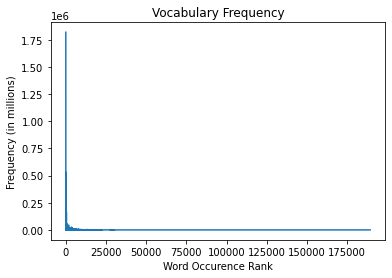

In [19]:
# YOUR CODE HERE
plt.plot(vocab_frequency.values())
plt.ylabel("Frequency (in millions)")
plt.xlabel("Word Occurence Rank")
plt.title("Vocabulary Frequency")
plt.show()

As you saw in the cells above, the dataset vocabulary is quite huge. Let's consider every token that occurs less than (or equal to) 5 times as a rare token. 

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Put these rare tokens in the **`rare_tokens` variable** and replace every rare token in the dataset with the `<unk>` token.
    
💻 API hint: Use `datasets.Dataset` utilities to manipulate the dataframe.
    
</div>

In [20]:
rare_threshold = 5
rare_tokens = set()

# YOUR CODE HERE
def repl(s, rare):
      for word in s.split():
            if word in rare:
                  s = s.replace(word, '<unk>')
      return s

rare_tokens = set([word for (word, freq) in vocab_frequency.items() if freq <= 5])

wikitext_dataset = wikitext_dataset.map(lambda x: {'text': repl(x['text'], rare_tokens)})

print(f"With threshold of {rare_threshold}, we have {len(rare_tokens)} rare tokens.\n",
      f"The vocabulary size is now {len(vocab_frequency) - len(rare_tokens)}")

Map:   0%|          | 0/432434 [00:00<?, ? examples/s]

With threshold of 5, we have 105822 rare tokens.
 The vocabulary size is now 83543


The dataset still includes many short samples which are not very useful for the language modeling task. We will filter out very short samples from the dataset. _(Note: Assume tokens can be achieved by simple `" "` splitting.)_
    

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

 🎯 Goal: Filter out every sample that has **less than (or equal to) 5 tokens**.
    
💻 API hint: Use `datasets.Dataset` utilities to manipulate the dataframe.

</div>

In [21]:
short_seq_threshold = 5

# YOUR CODE HERE
wikitext_dataset = wikitext_dataset.filter(lambda x: len(x['text'].split(" ")) >= 5)

print(f"Size of the dataset is {len(wikitext_dataset)}")

Filter:   0%|          | 0/432434 [00:00<?, ? examples/s]

Size of the dataset is 418914


After replacing rare tokens with <unk>, we could have sentences like `<unk> <unk> <unk> <unk>` which are again not very useful for language modeling. We will **filter out samples that more than 5% of its tokens are `<unk>`**.

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal:  **Filter out samples that more than 5% of its tokens are `<unk>`**
    
💻 API hint: Use `datasets.Dataset` utilities to manipulate the dataframe.

</div>

In [22]:
unknown_token_threshold = 0.05  # every sample that more than 5% of its tokens are <unk> should be removed

# YOUR CODE HERE
wikitext_dataset = wikitext_dataset.filter(lambda x: x['text'].count('<unk>')/len(x['text'].split(' ')) <= unknown_token_threshold)
print(f"Size of the dataset is {len(wikitext_dataset)}")

Filter:   0%|          | 0/418914 [00:00<?, ? examples/s]

Size of the dataset is 379455


Let's recalculate the vocabulary for the resulting dataset, to see the vocabulary of the resulting dataset.

In [23]:
vocab_frequency = compute_token_frequency(wikitext_dataset)

print(f"\nvocabulary size of the dataset is {len(vocab_frequency)}")


vocabulary size of the dataset is 83703


---

<a name="12"></a>
## 1.2 PyTorch Dataset  creation

After the pre-processing of the dataset, we will now create a `torch.Dataset` class for the wiki-text dataset. 
We need to do so, in order to transform the dataset to the right format for the language modeling task. 
The following steps should be implemented:

- Add `<start>` and `<stop>` tokens at the beginning and end of a sentence respectively.
- Add padding tokens ( `<pad>` ) at the end of the sentences.
- Create a fallback to <unk> token if an unseen word is encoded.
- Define dictionaries that map tokens to their respective index in the embedding matrix and vice versa.


### Create the RNN Dataset

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal:  **Go to the `utils.py` file, and fill in the `RNNDataset` class with your implemenation.**
    
</div>

In [26]:
from torch.utils.data import Dataset, DataLoader
import datasets
from src.utils import RNNDataset

MAX_SEQ_LENGTH = 128

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal:  **Instantiate** the implemented RNNDataset.
    
</div>

In [23]:
# YOUR CODE HERE
rnn_dataset = RNNDataset(wikitext_dataset, MAX_SEQ_LENGTH)

### Split data into train and test

Once we have created the dataset ready for the model training pipeline, we will split it into train and test datasets. Then we will pass them to a `DataLoader` class, following the same method we saw in the exercises session. 

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal:  **Split** the implemented RNNDataset into train and test subsets.
    
    

</div>

In [25]:
TRAIN_RATIO = 0.9

dataset_length = rnn_dataset.__len__() # this length is different from the wikitext_dataset length because I have removed those examples that become more than 128 tokens after adding start and stop
train_length = math.floor(dataset_length * TRAIN_RATIO)
test_length = dataset_length - train_length

rnn_train_dataset, rnn_test_dataset = torch.utils.data.random_split(rnn_dataset,
                                                               [train_length, test_length],
                                                               generator=torch.Generator().manual_seed(student_seed))

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">
    
🎯 Goal:  Create `DataLoader` objects using `batch_size = 8` for the train and test subsets.
    
</div>

In [26]:
train_dataloader = DataLoader(rnn_train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(rnn_test_dataset, batch_size=8, shuffle=False)

<div style="padding:15px 15px 15px 15px;border-left:3px solid #8e7cc3;background-color:#e4e1eb;border-radius: 15px;">

🎉 Excellent work! By this point, you will have made all the needed steps to make your data ready for training. 

#### Part 1 - Checklist
Here are the core building blocks you created and that you will need for Part 2:
   
- [X] `rnn_dataset`: A Dataset obj with the data, the vocabulary, the pad index, the max sequence length, and maps of idx to word type and vice versa. 
- [X] `train_dataloader`: A DataLoader obj with your training data
- [X] `test_dataloader`: A DataLoader obj with your testing data


_Tip: Try to familiarize yourself with these objects and what functionalities and attributes they provide._
    
</div>

---

<a name="2"></a>
# PART 2:  Training Language Models 🤗

#### Language Model: a probabilistic model of a sequence of tokens.

🔵 **What?**

Language modeling (LM) is the use of various statistical and probabilistic techniques to determine the probability of a given sequence of words occurring in a sentence. Language models analyze bodies of text data to provide a basis for their word predictions. They are used in natural language processing (NLP) applications, particularly ones that generate text as an output. Some of these applications include, machine translation and question-answering.

🟡 **How?**

There are several different probabilistic approaches to modeling language, which vary depending on the purpose of the language model. From a technical perspective, the various types differ by the amount of text data they analyze and the math they use to analyze it (architecture). Some LMs we've already seen and will learn about during lectures are n-gram / count-based models, Recurrent Neural Networks (RNNs), and Transformer models. 

🟣 **Why?**

Language modeling is crucial in modern NLP applications. It is the reason that machines can understand qualitative information. Each language model type, in one way or another, turns qualitative information into quantitative information. This allows people to communicate with machines as they do with each other to a limited extent. It is used directly in a variety of industries including tech, finance, healthcare, transportation, legal, military and government. Additionally, it's likely most people reading this have interacted with a language model in some way at some point in the day, whether it be through Google search, an autocomplete text function or engaging with a voice assistant.

ℹ️ Source: [Original article](https://www.techtarget.com/searchenterpriseai/definition/language-modeling#:~:text=Language%20models%20determine%20word%20probability,predict%20or%20produce%20new%20sentences.)



<div style="padding:15px 15px 15px 15px;border-left:3px solid gray;background-color:#F3F3F3;border-radius: 15px;">

In this part, you will train your own language models using the dataset created in Part 1.

More specifically, you need to implement **5 different model variants**, train and test them to compute their perplexity.
    
| Model | Variant | Description |
|:---- |:----- | :----- |
| | Token embeddings trained from scratch | An LSTM model with a trainable token Embedding layer <br>that will be initialized randomly and trained from scratch along with the LM. |
| **LSTM** | Pre-trained token embeddings & frozen | An LSTM model with pre-trained GloVe embeddings as input <br>that will be frozen while the LM is training. |
|  | Pre-trained token embeddings & trainable | An LSTM model with pre-trained GloVe embeddings as input <br>that will be further trained along with the LM. |
||||
| **Transformer** | Trained from scratch | A Transformer based model that follows the architecture of [DistilGPT2](https://huggingface.co/distilgpt2). |
|  | Pre-trained DistilGPT2 | A pre-trained Transformer based model called [DistilGPT2](https://huggingface.co/distilgpt2) <br>and will be used only for testing (not training). |
    
</div>

---
<a name="21"></a>
## 2.1 LSTM-variants


### 2.1.1 Implementing all LSTM variants in one Model class

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal:  **Go to the `utils.py` file, and fill in the `VanillaLSTM` class with your implemenation.**
    
💻 Implementation hint: You will create one model class for all variants. Try to incorporate all the different cases into one Model class.
    
</div>

In [27]:
from src.utils import VanillaLSTM

### 2.1.2 Building training and testing pipelines

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal:  Implement training and testing pipelines.
  
💻 Implementation hint: Check the pipelines we created in the exercises sessions.
    
</div>

In [100]:
def train(model, train_loader, optimizer, criterion, var, frac=0.1):
    """
    Main training pipeline. Implement the following:
    - pass inputs to the model
    - compute loss
    - perform backward pass and update weights

    :param model: 
    :param train_loader:
    :param optimizer:
    :param criterion: 
    return: 
    """
    
    # YOUR CODE HERE
    
    # Training loop
    model.to(device)
    model.train()
    for epoch in range(1):
        epoch_loss = 0.0
        print_loss = 0
        for (i, sentence) in tqdm(enumerate(train_loader)):
            sentence=sentence.to(device)
            optimizer.zero_grad()
            loss = model(sentence)
            loss.backward()
            optimizer.step()

            tb_writer.add_scalar(var+"/train_loss", loss.item(), i)
            epoch_loss += loss.item()
            print_loss += loss.item()
            if i % 1000 == 999. :    # print every 5000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {print_loss / 1000:.3f}')
                print_loss = 0.0
              
            if i >= frac * len(train_loader):
              break
    
    return epoch_loss / len(train_loader)

In [101]:
def test(model, test_loader, criterion, var, frac=0.1):
    """
    Main testing pipeline. Implement the following:
    - pass inputs to the model
    - compute loss
    - compute perplexity

    :param model: 
    :param test_loader:
    :param criterion: 
    return: 
    """
    
    # YOUR CODE HERE
    model.eval()
    test_loss = []
    # Testing loop
    with torch.no_grad():
        for i, sentence in tqdm(enumerate(test_loader)):
            sentence = sentence.to(device)
            loss = model(sentence)
            test_loss.append(loss.item())
            
            if i >= frac * len(test_loader):
              break

    test_loss = np.array(test_loss).mean()
    perplexity = np.exp(test_loss) # Since loss is cross-entropy
    
    print(f'Test loss: {test_loss:.3f}')
    print(f'Test Perplexity: {perplexity:.3f}')
    tb_writer.add_scalar(var+"/test_loss", test_loss, 0)
    tb_writer.add_scalar(var+"/test_perplexity", perplexity, 0)
    return test_loss, perplexity

### 2.1.3 Train and test LSTM variants

For **all the LSTM variants** you will perform the following steps:

1. Set hypeparameters
2. Load embeddings if needed
3. Instantiate the model and set training configurations
4. Run training pipeline (from 2.1.2)
5. Save the model
6. Run testing pipeline and compute perplexity (from 2.1.2)

#### LSTM Variant A: Embeddings trained from scratch

An LSTM model with a trainable Embedding layer that will be initialized randomly and trained from scratch along with the LM.

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Set hyperparameters according to the objective of the model.
      
💻 Implementation hint: You can play arround with different values for `dropout_rate`, `lr` and `num_layers`.

</div>

In [102]:
# YOUR CODE HERE
vocab_size = len(vocab_frequency) + 4 # start, stop, pad and unknown
embedding_dim = 100
hidden_dim = 100
num_layers = 1
dropout_rate = .001
lr = .01  # learning rate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Instantiate the **model, optimizer and loss**.
      
💻 Implementation hint: Choose your training settings according to the task you need to do.

</div>

In [103]:
# YOUR CODE HERE
model = VanillaLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, rnn_dataset.pad_idx)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss(ignore_index = rnn_dataset.pad_idx)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 16,905,907 trainable parameters


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Run **training and testing pipelines** on **10% data** (train and test) and compute perplexity.
      
</div>

In [107]:
tb_writer = SummaryWriter(log_dir='tensorboard/')
train(model, train_dataloader, optimizer, criterion, "LSTM_LM_variant_A", 0.1)
tb_writer.flush()
torch.save(model.state_dict(), 'models/lstm_with_random_token_embedding.pt')

1000it [03:33,  4.71it/s]

[1,  1000] loss: 6.829


2000it [07:06,  4.67it/s]

[1,  2000] loss: 6.439


3000it [10:39,  4.72it/s]

[1,  3000] loss: 6.334


4000it [14:12,  4.68it/s]

[1,  4000] loss: 6.287


4160it [14:46,  4.69it/s]


In [108]:
tb_writer = SummaryWriter(log_dir='tensorboard/')
test(model, test_dataloader, criterion, "LSTM_LM_variant_A", 0.1)
tb_writer.flush()

463it [00:45, 10.12it/s]

Test loss: 6.266
Test Perplexity: 526.442


#### LSTM Variant B: Pre-trained embeddings & frozen

An LSTM model with pre-trained GloVe embeddings as input that will be frozen while the LM is training.

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Download **GloVe embeddings**.
      
</div>

In [109]:
import gensim.downloader
# Download the "glove-wiki-gigaword-100" embeddings
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Create an embedding layer with dimensions that match the input of `VanillaLSTM` model and initialize it with random weights.
    
💻 API hint: Use `torch.nn.Embedding` class.
      
</div>

In [110]:
# YOUR CODE HERE
initial_embedding_weight = nn.Embedding(len(rnn_dataset.vocab), model.embedding_dim, padding_idx=rnn_dataset.pad_idx)

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Add each GloVe embedding in the respective position in the Embedding layer created in previous step.

💻 API hint: Use `.key_to_index` and `.word_to_index` functions.
      
</div>

In [111]:
# YOUR CODE HERE
emb_matrix = np.zeros((len(rnn_dataset.vocab), model.embedding_dim))

for i in range(1, len(rnn_dataset.vocab)):
  if rnn_dataset.index_to_word[i] in glove_vectors:
    emb_matrix[i] = glove_vectors[rnn_dataset.index_to_word[i]]
  else:
    emb_matrix[i] = initial_embedding_weight(torch.tensor(i)).detach().numpy()

glove_initial_wts = torch.from_numpy(emb_matrix).float()

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Instantiate the **model, optimizer and loss**.
      
💻 Implementation hint: Choose your training settings according to the task you need to do.

</div>

In [112]:
# YOUR CODE HERE
model = VanillaLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, rnn_dataset.pad_idx, embedding_weights=glove_initial_wts, freeze_embeddings=True)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss(ignore_index = rnn_dataset.pad_idx)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 8,535,207 trainable parameters


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Run **training and testing pipelines** on **10% data** (train and test) and compute perplexity.
      
</div>

In [122]:
tb_writer = SummaryWriter(log_dir='tensorboard/')
train(model, train_dataloader, optimizer, criterion, "LSTM_LM_variant_B", 0.1)
torch.save(model.state_dict(), 'models/lstm_with_frozen_glove_token_embedding.pt')
tb_writer.flush()

1000it [03:25,  4.90it/s]

[1,  1000] loss: 9.015


2000it [06:50,  4.78it/s]

[1,  2000] loss: 7.863


3000it [10:15,  4.92it/s]

[1,  3000] loss: 7.563


4000it [13:40,  4.88it/s]

[1,  4000] loss: 7.367


4160it [14:13,  4.87it/s]


In [123]:
tb_writer = SummaryWriter(log_dir='tensorboard/')
test(model, test_dataloader, criterion, "LSTM_LM_variant_B", 0.1)
tb_writer.flush()

463it [00:45, 10.14it/s]

Test loss: 7.289
Test Perplexity: 1464.670


#### LSTM Variant C: Pre-trained embeddings & trainable	
An LSTM model with pre-trained GloVe embeddings as input that will be further trained along with the LM.

_Note: Use the same embedding layer you instantiated with GloVe embeddings in the previous step_

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Instantiate the **model, optimizer and loss**.
      
💻 Implementation hint: Choose your training settings according to the task you need to do.

</div>

In [124]:
# YOUR CODE HERE
model = VanillaLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, rnn_dataset.pad_idx, embedding_weights=glove_initial_wts, freeze_embeddings=False)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss(ignore_index = rnn_dataset.pad_idx)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 16,902,907 trainable parameters


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Run **training and testing pipelines** on **10% data** (train and test) and compute perplexity.
      
</div>

In [125]:
tb_writer = SummaryWriter(log_dir='tensorboard/')
train(model, train_dataloader, optimizer, criterion, "LSTM_LM_variant_C", 0.1)
torch.save(model.state_dict(), 'models/lstm_with_nonfreezed_glove_token_embedding.pt')
tb_writer.flush()

1000it [03:27,  4.83it/s]

[1,  1000] loss: 9.041


2000it [06:54,  4.77it/s]

[1,  2000] loss: 7.880


3000it [10:22,  4.85it/s]

[1,  3000] loss: 7.538


4000it [13:49,  4.82it/s]

[1,  4000] loss: 7.364


4160it [14:22,  4.82it/s]


In [126]:
tb_writer = SummaryWriter(log_dir='tensorboard/')
test(model, test_dataloader, criterion, "LSTM_LM_variant_C", 0.1)
tb_writer.flush()

463it [00:45, 10.19it/s]


Test loss: 7.278
Test Perplexity: 1448.280


---

<a name="22"></a>
## 2.2 Transformer-variants

For all Transformer vairants we will use the architecture of **DistilGPT2** model. DistilGPT2 (short for Distilled-GPT2) is an English-language model pre-trained with the supervision of the smallest version of Generative Pre-trained Transformer 2 (GPT-2). Like GPT-2, DistilGPT2 can be used to generate text. See more details in the [HuggingFace model card](https://huggingface.co/distilgpt2). 

### 2.2.1 Train DistilGPT-2 from scratch

You will perform the following steps:

1. Load the config of the DistilGPT-2 model using the Transformers library.
2. Load Model class from the config and the respective tokenizer.
3. Change input dataset to fit with the tokenization mechanism of DistilGPT-2.
4. Split dataset into train and test.
5. Create DataLoaders for train and test subsets.
6. Train the model from stratch.
7. Test the model and compute perplexity

In [27]:
model_name = "distilgpt2"
tokenizer_checkpoint = "distilgpt2"

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Load model config, model class and tokenizer.
      
💻 Implementation hint: You should load the **model instance** and not the pre-trained model weights. You should load the pre-trained tokenizer though.

</div>

In [28]:
MAX_SEQ_LENGTH = 128

# YOUR CODE HERE
model_config = AutoConfig.from_pretrained(model_name)
gpt2_scratch_model = GPT2LMHeadModel._from_config(config=model_config)
gpt_tokenizer = GPT2TokenizerFast.from_pretrained(tokenizer_checkpoint, padding_side='right', )

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Implement the following steps according to the in-line comments.

</div>

In [41]:
# Training on 1/100th here itself to reduce time in all following steps
wikitext_dataset10 = wikitext_dataset.shard(num_shards=500, index=0)

In [42]:
# YOUR CODE HERE
import pandas as pd


# add pad_token the same as the EOS token to not increase vocab size
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

tokens = []
input_ids, attention_mask = [], []
# tokenize wikitext_dataset with pre-trained DistilGPT2 tokenizer
# create input_ids and attention_mask columns in the dataset
for sentence in tqdm(wikitext_dataset10['text']):
  tkizer = gpt_tokenizer(sentence, padding='max_length', add_special_tokens=True, truncation=True, max_length=MAX_SEQ_LENGTH)
  s_tokens = gpt_tokenizer.tokenize(sentence, padding='max_length', add_special_tokens=True, truncation=True, max_length=MAX_SEQ_LENGTH)
  tokens.append(s_tokens)
  input_ids.append(tkizer.input_ids)
  attention_mask.append(tkizer.attention_mask)


100%|██████████| 759/759 [00:01<00:00, 690.83it/s]


In [43]:
# Making this a dataset
from datasets import Dataset

encoded_dataset = Dataset.from_pandas(pd.DataFrame(list(zip(tokens, input_ids, attention_mask, input_ids)), 
                                 columns=['tokens', 'input_ids', 'attention_mask', 'labels']))

In [44]:
# Garbage Collection
import gc
gc.collect()

18

In [45]:
# filter out sentences with length more than MAX_SEQ_LENGTH
limited_encoded_dataset = encoded_dataset.filter(lambda x: len(x['tokens']) <= MAX_SEQ_LENGTH)

Filter:   0%|          | 0/759 [00:00<?, ? examples/s]

In [46]:
# limited_encoded_dataset = limited_encoded_dataset.remove_columns("tokens")
limited_encoded_dataset = limited_encoded_dataset.with_format("torch")

In [47]:
import gc
gc.collect()

53

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal:  **Split** the `limited_encoded_dataset` into train and test subsets.
    
💻 API hint: Use `torch.utils.data.random_split` method with the given `TRAIN_RATIO`.

</div>

In [48]:
# YOUR CODE HERE
from torch.utils.data import random_split

TRAIN_RATIO = 0.9
dataset_length = len(limited_encoded_dataset)
train_length = int(dataset_length * TRAIN_RATIO)
test_length = dataset_length - train_length

transformer_train_dataset, transformer_test_dataset = random_split(limited_encoded_dataset, [train_length, test_length])

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Set hyperparameters according to the objective of the model.
      
💻 Implementation hint: You can play arround with different values for `learning_rate`.

</div>

In [49]:
# YOUR CODE HERE
training_args = TrainingArguments(
    output_dir=f"{model_name}-wikitext103",
    evaluation_strategy = "epoch",
    logging_steps=10,
    learning_rate=0.01,
    save_steps=100,
    weight_decay=0.01,
    num_train_epochs=1)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Run **training** using the `Trainer` class on **10% of data**.

</div>

In [50]:
gpt2_scratch_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [51]:
from transformers import DataCollatorWithPadding, DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=gpt_tokenizer, mlm=False)
# data_collator = DataCollatorWithPadding(tokenizer=gpt_tokenizer)


trainer = Trainer(model=gpt2_scratch_model, 
                  args=training_args, 
                  train_dataset=transformer_train_dataset,
                  eval_dataset=transformer_test_dataset,
                  tokenizer=gpt_tokenizer,
                  data_collator=data_collator)

In [52]:
trainer.train()
torch.save(trainer.model.state_dict(), 'models/distilgpt2-lm-from-scratch.pt')

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,7.617400,7.572906


## Distill GPT2 from Scratch Model Checkpoint

Link for the pt file, was too large (334 MB) for git lfs: https://drive.google.com/file/d/1Uy6Xc_buhBPWqrrW0tGixhTVbAmtQVRv/view?usp=sharing

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Run **testing** using the `Trainer` class and compute perplexity.

      
</div>

In [427]:
eval_result = trainer.evaluate()
perplexity_from_scratch = math.exp(eval_result["eval_loss"])
print(f"The perplexity on the test dataset is {perplexity_from_scratch:.3f}")

The perplexity on the test dataset is 1236.115


### 2.2.2 Run Pre-trained GPT-2 model

After training your trained-from-scratch Transformer model in the previous section, you will now use a pre-trained model to find its perplexity. Therefore, we will only perform testing of the pre-trained model on the test dataset. 

You will perform the following steps:

1. Load pre-trained model and tokenizer
2. Run testing and compute perplexity

In [428]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, AutoConfig, AutoModelForCausalLM, AutoTokenizer
from transformers import Trainer, TrainingArguments
import torch

model_id = "distilgpt2"

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Load pre-trained model and tokenizer.
      
</div>

In [429]:
# YOUR CODE HERE
gpt2_pretrained_model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer_pretrained_gpt = GPT2TokenizerFast.from_pretrained(model_id)
tokenizer_pretrained_gpt.pad_token = gpt_tokenizer.eos_token

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Set hyperparameters to set up the Trainer.
      
💻 Implementation hint: We will use only the inference part on the trainer.

</div>

In [430]:
# YOUR CODE HERE
training_args = TrainingArguments(
    output_dir=f"pretrained_{model_id}-wikitext103",
    evaluation_strategy = "epoch",
    logging_steps=100,
    learning_rate=0.01,
    save_steps=10000,
    weight_decay=0.01,
    num_train_epochs=1)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Run **testing** using the `Trainer` class and compute perplexity.
      
</div>

In [432]:
data_collator = DataCollatorForLanguageModeling(tokenizer=gpt_tokenizer, mlm=False)
pretrained_trainer = Trainer(model=gpt2_pretrained_model, 
                  args=training_args, 
                  train_dataset=transformer_train_dataset,
                  eval_dataset=transformer_test_dataset,
                  tokenizer=tokenizer_pretrained_gpt,
                  data_collator=data_collator)

In [433]:
eval_result = pretrained_trainer.evaluate()
perplexity_pretrained_model = math.exp(eval_result["eval_loss"])
print(f"The perplexity of pretrained {model_id} on the test dataset is {perplexity_pretrained_model:.3f}")

The perplexity of pretrained distilgpt2 on the test dataset is 126.399


<div style="padding:15px 15px 15px 15px;border-left:3px solid #8e7cc3;background-color:#e4e1eb;border-radius: 15px;">
    
🎉  Excellent work! By this point, you will have implemented all language model variants.

#### Part 2 - Checklist
Here are the core building blocks you created and that you will need for Part 3:
   
- [X] LSTM-variants checkpoints.
- [X] LSTM-variants ppl scores.
- [X] Transformer-variants ppl scores.

_Note: Don't forget to include the tensorboard log to every model you trained, as discussed in the `README.md` of `tensorboard/` dir._
</div>

---

<a name="3"></a>
# PART 3: Fine-tune on the Text Paraphrasing task 🚀

In this part, we will fine-tune and test the language models into the downstream task of text Paraphrasing. 

For this task, we will use the [MRPC dataset](https://paperswithcode.com/dataset/mrpc). Microsoft Research Paraphrase Corpus (MRPC) is a corpus consisting of 5,801 sentence pairs collected from newswire articles. Each pair is labeled if it is a paraphrase or not by human annotators. 

 ![mrpc.png](https://github.com/CS-552/a1-amey-kulkarni27/blob/main/docs/mrpc.png?raw=1)
 
## Models
For this dataset, we will select only the ones that correspond to text paraphrasing (label 1). With those, we will test the model's ability to take as input a sentence and produce as output the paraphrased one. 

### Encoder-Decoder architectures: 
To create a sequence2sequence model, we will create an Encoder-decoder model with an attention mechanism similar to the week 3 exercises.

More specifically you need to implement the following:
- Preprocess the dataset to match with the format of the model's input.
- Build a Encoder-Decoder model that will be trained from stratch on the text paraphrasing task.
- Train and test your architectures and compute the train/validation loss score. 

### Transformer-based architectures:

You will also run experiments with the pre-trained Transformer-based model as we did in Part 2. 
You will be using again DistilGPT2. More specifically you need to implement the following:

- Preprocess the dataset to match with the format of the model's input.
- Run training (fine-tuning) of the model on train dataset.
- Run inference on the test set and compute evaluation scores (see section below).


#### Evaluation for the Transformer model

You will evaluate your model using ROUGE scores. 
 
**ROUGE score** stands for Recall-Oriented Understudy for Gisting Evaluation. In its simplest form ROUGE score is the quotient of the matching words under the total count of words in reference sentence. Regarding the denominator ROUGE is a recall oriented metric. 

![rouge.png](https://github.com/CS-552/a1-amey-kulkarni27/blob/main/docs/rouge.png?raw=1)

**ROUGE-L score** is based on the length of the longest common subsequence (LCS). To counter the disadvantages of a pure recall metric as in ROUGE-N, Rouge-L calculates the weighted harmonic mean (or f-measure) combining the precision score and the recall score.

![rouge_l.png](https://github.com/CS-552/a1-amey-kulkarni27/blob/main/docs/rouge_l.png?raw=1)

ℹ️ Source: [Original article](https://clementbm.github.io/theory/2021/12/23/rouge-bleu-scores.html#bleu)


### Load MPRC dataset and extract the paraphrased ones

In [434]:
from datasets import load_dataset
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [436]:
# load dataset
mrpc_dataset = load_dataset("glue", "mrpc")
MAX_SEQ_LENGTH = 64

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Keep only the **paraphrased pair** of sentences.

</div>

In [437]:
# YOUR CODE HERE
mrpc_dataset = mrpc_dataset.remove_columns(['label', 'idx'])

<a name="31"></a>
## 3.1 Train Encoder-Decoder models on Text Paraphrasing

In this part, you will preprocess the dataset to make it suitable for the Encoder-Decoder model by adding `<start>` and `<stop>` tokens on each sentences and then padding to the maximum sequence length. From now on, we will refer to sentence 1 as context and sentence 2 as reference. Finally, you will compute the train/validation loss score.

### Data Preprocessing for encoder-decoder

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Add  `<start>` and `<stop>` tokens and pad the input to `MAX_SEQ_LENGTH` length.

</div>

In [438]:
# YOUR CODE HERE
rnn_word_to_idx = rnn_dataset.word_to_index

# tokenizing the texts in the mrpc
modes = ['train', 'validation', 'test']
for mode in modes:
  tokens1 = []
  tokens2 = []
  for s in mrpc_dataset[mode]['sentence1']:
    token = [rnn_word_to_idx.get('<start>', rnn_dataset.unk_idx)]
    token.extend([rnn_word_to_idx.get(word, rnn_dataset.unk_idx) for word in s.split()])
    token.append(rnn_word_to_idx.get('<stop>', rnn_dataset.unk_idx))
    tokens1.append(token)
  for s in mrpc_dataset[mode]['sentence2']:
    token = [rnn_word_to_idx.get('<start>', rnn_dataset.unk_idx)]
    token.extend([rnn_word_to_idx.get(word, rnn_dataset.unk_idx) for word in s.split()])
    token.append(rnn_word_to_idx.get('<stop>', rnn_dataset.unk_idx))
    tokens2.append(token)
  mrpc_dataset[mode] = mrpc_dataset[mode].add_column("tokens1", tokens1)
  mrpc_dataset[mode] = mrpc_dataset[mode].add_column("tokens2", tokens2)


# pad sequences
mrpc_dataset = mrpc_dataset.map(lambda x: {'tokens1': x['tokens1']+[rnn_dataset.pad_idx]*(MAX_SEQ_LENGTH-len(x['tokens1']))})
mrpc_dataset = mrpc_dataset.map(lambda x: {'tokens2': x['tokens2']+[rnn_dataset.pad_idx]*(MAX_SEQ_LENGTH-len(x['tokens2']))})

mrpc_dataset = mrpc_dataset.remove_columns(["sentence1", "sentence2"])
mrpc_dataset = mrpc_dataset.with_format("torch")

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [439]:
mrpc_train, mrpc_validation, mrpc_test = mrpc_dataset["train"], mrpc_dataset["validation"], mrpc_dataset["test"]

mrpc_train_dataloader = DataLoader(mrpc_train, batch_size=8, shuffle=True)
mrpc_validation_dataloader = DataLoader(mrpc_validation, batch_size=8, shuffle=False)
mrpc_test_dataloader = DataLoader(mrpc_test, batch_size=8, shuffle=False)

### Run model fine-tuning

In [440]:
# import your end-dec model
from src.utils import EncoderDecoder

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal:  Implement training and testing pipelines.
  
💻 Implementation hint: Check the pipelines we created in the exercises sessions.
    
</div>

In [ ]:
def seq2seq_train(model, train_loader, eval_loader, optimizer, criterion, num_epoch):
    
    best_eval_loss = 1e3 # used to do early stopping
        
    # Training loop
    for epoch in range(num_epoch):
        running_loss = 0
        epoch_loss = 0
        for i, data in (enumerate(train_loader)):
             
            # YOUR CODE HERE
            pass

    return epoch_loss / len(train_loader)

In [ ]:
def seq2seq_eval(model, eval_loader, criterion):
    # this function should be called in the train loop to monitor the performance in validation set while training.
    
    running_loss = 0
    epoch_loss = 0
    for i, data in (enumerate(eval_loader)):
        # YOUR CODE HERE
        pass

    return epoch_loss / len(eval_loader)

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Instantiate the **model, optimizer and loss**.
      
💻 Implementation hint: Choose your training settings according to the task you need to do.

</div>

In [ ]:
seq2seq_with_attention_model = EncoderDecoder(...)
optimizer = ...
criterion = ...
num_params = sum(p.numel() for p in seq2seq_with_attention_model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Run **training and testing pipelines**.
      
</div>

In [ ]:
seq2seq_train(...)
# saving the model
torch.save(seq2seq_with_attention_model.state_dict(), "models/rnn_seq2seq_with_attention.pt")

<a name="32"></a>
## 3.2 Run Transformer on Text Paraphrasing

In this part you will need to concatinate the paraphrased pair of sentences into one sequence to serve as input. Then we will use this input to pass it to the DistilGPT2 model for fine-tuning and testing.
The input should be the following:
```
<sentence_1> <eos> <sentence_2> <eos>
```
where `<eos>` is the tokenizer's end-of-sequence token.

From now on, we will refer to sentence 1 as `context` and sentence 2 as `reference`. 

Here, we use a decoder-only model (DistilGPT2) which gets the **context** as input and generates the **reference** sequence (token-by-token). Given this token-by-token generation, the nature of the model is very similar to a language model; the major difference is that in general causal language models try to predict the next token for the whole input, whereas in this case, the model should generate only the **reference**. (i.e., the **context** should be masked for loss computation).  

Finally, you will compute the ROUGE scores as follows:

1. You will generate 5 sequences given each context.
2. You will compute the ROUGE-L score among these 5 generations and the **context** => `ROUGE(context, generationX)`
3. You will select the best generation (among the 5 ones) as the predicted reference.
4. You will compute the ROUGE-(1, 2, L) scores between the top generation (from step 3) and the **reference** => `ROUGE(reference, top-generation)`
5. You will provide the average ROUGE-(1, 2, L) scores for all the test dataset samples.

### Data Preprocessing for Transformers

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Load pre-trained **model** and **tokenizer**.
      
</div>

In [308]:
# !rm -r ../root/.cache

In [54]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2TokenizerFast

model_id = "distilgpt2"
mrpc_dataset = load_dataset("glue", "mrpc")

# YOUR CODE HERE
gpt2_pretrained_model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer_pretrained_gpt = GPT2TokenizerFast.from_pretrained(model_id)

  0%|          | 0/3 [00:00<?, ?it/s]

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Concatenate sentences, pass them to the tokenizer and clip to `MAX_SEQ_LENGTH` length.
      
</div>

In [55]:
tokenizer_pretrained_gpt.pad_token = tokenizer_pretrained_gpt.eos_token
eos_token = tokenizer_pretrained_gpt.eos_token
eos_token_id = tokenizer_pretrained_gpt.eos_token_id

# YOUR CODE HERE

# concatenate sentences along with <eos> and pass them to the tokenizer
mrpc_dataset = mrpc_dataset.map(lambda x: {'concat': x['sentence1'] + ' ' + eos_token + ' ' + x['sentence2'] + ' ' + eos_token})

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [56]:
# cut input and attention mask to MAX_SEQ_LENGTH
mrpc_dataset = mrpc_dataset.filter(lambda x: len(x['concat']) <= 2*MAX_SEQ_LENGTH)

Filter:   0%|          | 0/3668 [00:00<?, ? examples/s]

Filter:   0%|          | 0/408 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1725 [00:00<?, ? examples/s]

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Apply the masking technique described above (mask context sequence).
      
</div>

In [59]:
input_ids, attention_mask = {}, {}
modes = ['train', 'validation', 'test']
for mode in modes:
  input_ids[mode], attention_mask[mode] = [], []
  for sentence in tqdm(mrpc_dataset[mode]['concat']):
    tkizer = tokenizer_pretrained_gpt(sentence, padding='max_length', add_special_tokens=True, truncation=True, max_length=MAX_SEQ_LENGTH)
    input_ids[mode].append(tkizer.input_ids)
    attention_mask[mode].append(tkizer.attention_mask)

100%|██████████| 820/820 [00:00<00:00, 4254.60it/s]


In [60]:
from datasets import Dataset
import pandas as pd
mrpc_train_dataset = Dataset.from_pandas(pd.DataFrame(list(zip(input_ids['train'], attention_mask['train'])), 
                                 columns=['input_ids', 'attention_mask']))
mrpc_eval_dataset = Dataset.from_pandas(pd.DataFrame(list(zip(input_ids['validation'], attention_mask['validation'])), 
                                 columns=['input_ids', 'attention_mask']))

In [61]:
def get_sample_label(sample):
    # this function masks the context (by assigning -100), and makes the paraphrase the target labels
    
    # YOUR CODE HERE
    output_label = sample['input_ids']
    for i in sample['input_ids']:
      output_label = -100
      if i == eos_token_id:
        break

    return {"labels": output_label} 

mrpc_train_dataset = mrpc_train_dataset.map(get_sample_label)
mrpc_eval_dataset = mrpc_eval_dataset.map(get_sample_label)


Map:   0%|          | 0/1734 [00:00<?, ? examples/s]

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

In [62]:
mrpc_train_dataset = mrpc_train_dataset.with_format("torch")
mrpc_eval_dataset = mrpc_eval_dataset.with_format("torch")

### Run model fine-tuning

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Set hyperparameters according to the objective of the model.
      
💻 Implementation hint: You can play arround with different values for `learning_rate`.

</div>

In [63]:
from transformers.models.gpt2.modeling_flax_gpt2 import GPT2Config
from transformers import TrainingArguments, Trainer, AutoModelForCausalLM

# create the finetuning trainer
training_args = TrainingArguments(
    output_dir=f"finetune_{model_id}-MRPC",
    evaluation_strategy = "epoch",
    logging_steps=100,
    learning_rate=0.02,
    num_train_epochs=20,
    save_steps=10000,
    weight_decay=0.01,
    report_to="none")

gpt2_pretrained_model.transformer.wte.weight.requires_grad = False
gpt2_pretrained_model.lm_head.weight.requires_grad = False
gpt2_pretrained_model.to(device)

/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: Run **training** using the `Trainer` class.
      
</div>

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer_pretrained_gpt, mlm=False)

paraphrasing_trainer = Trainer(
                  model=gpt2_pretrained_model, 
                  args=training_args, 
                  train_dataset=mrpc_train_dataset,
                  eval_dataset=mrpc_eval_dataset,
                  tokenizer=tokenizer_pretrained_gpt,
                  data_collator=data_collator)

paraphrasing_trainer.train()
torch.save(paraphrasing_trainer.model.state_dict(), 'models/finetune-distilgpt2-mrpc.pt')

## Fine Tune DistilGPT2 MRPC Model Checkpoint

Link for the pt file, was too large (334 MB) for git lfs: https://drive.google.com/file/d/1fEir4JMhARxQCI7J2AFsk77hBUJkFlr2/view?usp=sharing

### Evaluate model with ROUGE scores

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;">

🎯 Goal: For each sample in evaluation set, generate 5 outputs and perform the ROUGE evaluation as presented in the question description above.

💻 Implementation hint: Use the following API call to get top-k generations
    
    generated_sequences = paraphrasing_trainer.model.generate(
        context_ids,
        do_sample=True, 
        max_length=MAX_SEQ_LENGTH, 
        top_k=20, 
        top_p=0.95, 
        no_repeat_ngram_size=2, 
        num_return_sequences=5
    )

_Note 1: For simplicity, you can ignore the contexts that have more than 1 sentence._

_Note 2: On the generated reference, if there is more that 1 sentence generated, keep only the first one._

_Note 3: To split into sentences, you can use [`nltk.sent_tokenize()`](https://www.nltk.org/api/nltk.tokenize.html)._

_Note 4: Use the [`evaluate.load('rouge')`](https://huggingface.co/spaces/evaluate-metric/rouge) function to compute the ROUGE metrics._

 
</div>

In [ ]:
!pip install evaluate
!pip install rouge-score

In [339]:
import evaluate
rouge = evaluate.load('rouge')

In [352]:
rouge_values1 = []
rouge_values2 = []
rouge_valuesL = []
rouge_valuesLsum = []

for sample in tqdm(mrpc_eval_dataset):
  generated_sequences = paraphrasing_trainer.model.generate(
    input_ids=sample['input_ids'].unsqueeze(0).to(device), attention_mask=sample['attention_mask'].unsqueeze(0).to(device),
    do_sample=True, 
    max_length=2*MAX_SEQ_LENGTH, 
    top_k=20, 
    top_p=0.95, 
    no_repeat_ngram_size=2, 
    num_return_sequences=5
  )
  for output in generated_sequences:
    line = tokenizer_pretrained_gpt.decode(output, skip_special_tokens=True,clean_up_tokenization_spaces=True)

  inpline = tokenizer_pretrained_gpt.decode(sample['input_ids'], skip_special_tokens=True,clean_up_tokenization_spaces=True)
    
  # # pick the best candidate given ROUGE similarity to context
  best_cand = None
  best_sc = -1
  for output in generated_sequences:
    line = tokenizer_pretrained_gpt.decode(output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
    a, b = len(inpline), len(line)
    c = min(a, b)
    results = rouge.compute(predictions=inpline[:c], references=line[:c], tokenizer=lambda x: x.split())
    if results['rougeL'] > best_sc:
      best_cand = line
      best_sc = results['rougeL']
            
  # compute the ROUGE value of the best candidate with the reference
  results = rouge.compute(predictions=inpline[:c], references=line[:c], tokenizer=lambda x: x.split())
  rouge_values1.append(results['rouge1'])
  rouge_values2.append(results['rouge2'])
  rouge_valuesL.append(results['rougeL'])
  rouge_valuesLsum.append(results['rougeLsum'])



  0%|          | 0/193 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Input length of input_ids is 128, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  1%|          | 1/193 [00:03<12:11,  3.81s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Input length of input_ids is 128, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  1%|          | 2/193 [00:06<09:19,  2.93s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.

In [353]:
print("Average ROUGE1 score: " + str(sum(rouge_values1)/len(rouge_values1)))
print("Average ROUGE2 score: " + str(sum(rouge_values2)/len(rouge_values2)))
print("Average ROUGEL score: " + str(sum(rouge_valuesL)/len(rouge_valuesL)))
print("Average ROUGEL score: " + str(sum(rouge_valuesLsum)/len(rouge_valuesLsum)))

Average ROUGE1 score: 0.829463689610282
Average ROUGE2 score: 0.0
Average ROUGEL score: 0.8294039261755698
Average ROUGEL score: 0.8293173172767819


<div style="padding:15px 15px 15px 15px;border-left:3px solid #8e7cc3;background-color:#e4e1eb;border-radius: 15px;">

🎉 Excellent work! You just finished the code implementation parts of the assignment. 

#### Part 3 - Checklist
Here are the elements you will need for the report in Part 4:
   
- [X] LSTM-variants scores on perplexity and their checkpoints.
- [X] DistilGPT2 score on perplexity and its checkpoint.
- [X] Encoder-decoder variant train/validation loss score and its checkpoint.
- [X] DistilGPT2 ROUGE scores and its fine-tuned checkpoint.

_Note: Don't forget to include the tensorboard log to every model you trained._


</div>

---

<a name="4"></a>
# PART 4: Write your report 📘

Fill in the tables with the respective scores. 

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;text-align:center;">

#### Perplexity results on Language Models

| Model - Variant | PPL |
|:--------- | :-----: |
| LSTM Variant A - Embeddings trained from scratch | 526.442|
| LSTM Variant B - Pre-trained embeddings & frozen | 1464.670 |
| LSTM Variant C - Pre-trained embeddings & trainable | 1448.280 |
||||
| DistilGPT2 - Trained from scratch | 1236.115 |
| Pre-trained DistilGPT2 | 126.399 |
    
#### Performance scores on Text Paraphrasing
| Model - Variant | ROUGE-1 | ROUGE-2 | ROUGE-L | ROUGE-Lsum |
|:--------- | :-----: | :-----: |  :-----: |  :-----: | 
| Pre-trained DistilGPT2 | 0.82946 |0 |  0.82940 |0.82931 |

</div>